In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import random
import shutil
import sklearn
import os

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir="/content/drive/MyDrive/train test different models"

In [5]:
train_ds = ImageFolder(data_dir+'/train', tt.Compose([tt.Resize((224, 224)), tt.ToTensor()]))
valid_ds = ImageFolder(data_dir+'/validate', tt.Compose([tt.Resize((224, 224)), tt.ToTensor()]))
test_ds = ImageFolder(data_dir+'/test', tt.Compose([tt.Resize((224, 224)), tt.ToTensor()]))

In [6]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(valid_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 930
Number of validation examples: 114
Number of testing examples: 271


In [7]:
BATCH_SIZE = 64
train_dl = DataLoader(train_ds, shuffle = True, batch_size = BATCH_SIZE)
valid_dl = DataLoader(valid_ds, shuffle = True, batch_size = BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE)

In [8]:
def show_batch(dl):
  for images, label in dl:
      # print(images.shape)
      fig, ax = plt.subplots(figsize=(12, 12))
      ax.set_xticks([]); ax.set_yticks([])
      grid_image=make_grid(images[:64],nrow=8)
      # print(grid_image.shape)
      ax.imshow(grid_image.permute(1,2,0))
      break

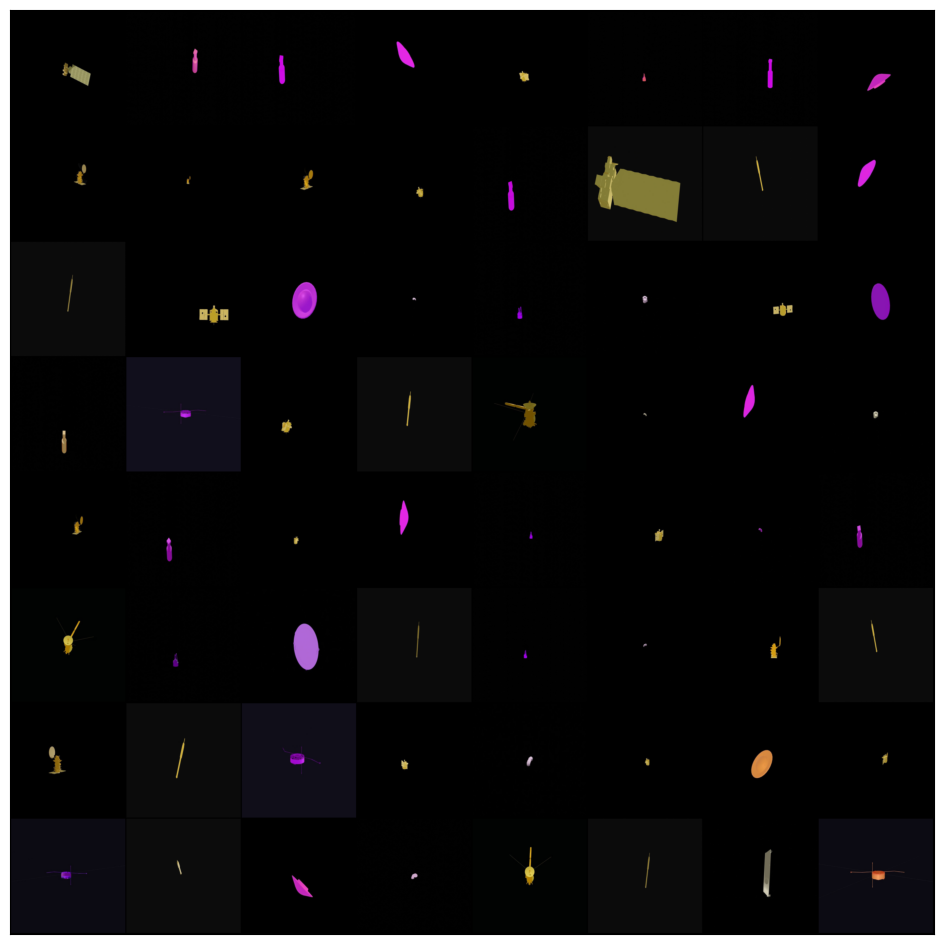

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cpu')

In [12]:
train_dl2 = DeviceDataLoader(train_dl, device)
valid_dl2 = DeviceDataLoader(valid_dl, device)
test_dl2 = DeviceDataLoader(test_dl, device)

In [14]:
!pip install torchmetrics
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 12.7 MB/s eta 0:00:00


In [15]:
import torchvision
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r
import torchmetrics
from torchmetrics.classification import F1Score
from torchmetrics.classification import Precision
from torcheval.metrics.functional import multiclass_f1_score

In [16]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def f1score(outputs, labels):
    f1 = F1Score(task="multiclass", num_classes=2).to(device)
    _, preds = torch.max(outputs, dim=1)
    return f1(preds, labels)

def precision(outputs, labels):
    precision = Precision(task="multiclass", num_classes=2).to(device)
    _, preds = torch.max(outputs, dim=1)
    return precision(preds, labels)

class SDDBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        prec = precision(out, labels)           # Calculate precision
        f1 = f1score(out, labels)             # Calculate f1 score
        return {'val_loss': loss.detach(), 'val_acc': acc, 'precision': prec, 'f1score': f1}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        batch_precision= [x['precision'] for x in outputs]
        epoch_precision = torch.stack(batch_precision).mean()   # Combine precision
        batch_f1= [x['f1score'] for x in outputs]
        epoch_f1 = torch.stack(batch_f1).mean()   # Combine f1
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'precision': epoch_precision.item(),'f1score': epoch_f1.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f},precision: {:.4f}, f1score: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc'], result['precision'], result['f1score']))

In [17]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

In [18]:
class SDDModel_VGG16(SDDBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier[6] = nn.Linear(4096, 2)

    def forward(self, xb):
        return self.network(xb)

In [24]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader] 
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
total_train = len(train_dl)
total_validate = len(valid_dl)

15

In [21]:
model2 = SDDModel_VGG16(len(train_ds.classes))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.5MB/s]


In [33]:
'''
history = model.fit_generator(
    train_dl2,
    epochs=epochs,
    validation_data=valid_dl2,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)
'''

'\nhistory = model.fit_generator(\n    train_dl2,\n    epochs=epochs,\n    validation_data=valid_dl2,\n    validation_steps=total_validate//batch_size,\n    steps_per_epoch=total_train//batch_size)\n'

In [23]:
history = [evaluate(model2, valid_dl2)]
history

[{'val_loss': 0.6578385829925537,
  'val_acc': 0.612500011920929,
  'precision': 0.612500011920929,
  'f1score': 0.612500011920929}]

In [25]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model2, train_dl2, valid_dl2, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from torchvision import models

class SDDModel(SDDBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)